# Preprocessing and quality control of NMR data with the nPYc-Toolbox

This tutorial demonstrates how to use the NMR data processing modules of the nPYc-Toolbox, to import and perform some basic preprocessing and quality control of NMR data and to output a final high quality dataset ready for data modeling.

Details of how to install all of the required dependencies and to set up your computing environment can be found in 'document.txt', and full documentation for the nPYc-Toolbox can be found on [read the docs](https://npyc-toolbox.readthedocs.io/en/latest/index.html)

The nPYc-Toolbox has been developed based on the quality control criteria previously described in [Dona et al. 2014](https://www.ncbi.nlm.nih.gov/pubmed/25180432)

The dataset used in this example (DEVSET U 1D NMR) is comprised of six samples of pooled human urine, aliquoted, and independently prepared and measured by 1H NMR spectroscopy. Each source sample was separately prepared and assayed thirteen times. A pooled QC sample (study reference, SR) and independent external reference (long-term reference, LTR) of a comparable matrix was also acquired to assist in assessing analytical precision. See the Metabolights Study [MTBLS694](https://www.ebi.ac.uk/metabolights/MTBLS694)

# 1. Import the nPYc-Toolbox and configure Jupyter notebook

In [1]:
toolboxPath = '/Users/cs401/Box Sync/Carolines code/phenomecentre/npyc-toolbox-master'

In [2]:
import sys
import pyChemometrics
sys.path.append(toolboxPath)

In [3]:
# Import the nPYc-Toolbox
import nPYc

# Import enumerations for sample type
from nPYc.enumerations import VariableType, DatasetLevel, AssayRole, SampleType

# Import normalisation objects for data normalisation
from nPYc.utilities.normalisation import NullNormaliser, TotalAreaNormaliser, ProbabilisticQuotientNormaliser

# Import matplotlib plotting, configure the Jupyter notebook to plot inline
import matplotlib.pyplot as plt
%matplotlib inline

# Set up plotly to work in offline mode with the notebook
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

# 2. Import and preprocess NMR data

The first step is to import the DEVSET U 1D NMR raw data files (Bruker format) into an nPYc-Toolbox [nmrData object](https://npyc-toolbox.readthedocs.io/en/latest/objects.html)

The "rawDataPath" parameter sets the location of the NMR raw data.

The NMR DevSet Dataset is located in 'DEVSET U 1D NMR raw data files'. This folder contains 94 directories, each corresponding to a spectrum acquired with the ‘noesygppr1d’ pulse sequence. The Fourier Transform, apodization and phasing have already been performed with the vendor software (ie, TopSpin).

In [4]:
rawDataPath = './DEVSET U 1D NMR raw data files'

The “sop” parameter points to a file which contains a set of parameters to use during data import and pre-processing. Each SOP file is encoded in JSON format. For full details see [Configuration Files](https://npyc-toolbox.readthedocs.io/en/latest/configuration/configuration.html).

The nPYc-Toolbox contains two default SOP files, GenericNMRUrine and GenericNMRBlood. These contain the recommended parameters for import and quality control of human urine and plasma/serum biofluid, respectively. Since this is a urine biofluid dataset, we will use the 'GenericNMRUrine' file.

In [5]:
sop = 'GenericNMRurine'

The "pulseProgram" parameter defines the specific NMR experiment pulse program to import, in this case 'noesygppr1d' - a standard 1D experiment with a NOE water pre-saturation. 

In [6]:
pulseProgram = 'noesygppr1d'

The following line triggers the pre-processing of the NMR spectra and creates an object representing the dataset:

In [7]:
nmrData = nPYc.NMRDataset(rawDataPath, pulseProgram=pulseProgram, sop=sop)

Any of the arguments present in the SOP file ([Configuration Files](https://npyc-toolbox.readthedocs.io/en/latest/configuration/configuration.html)) can be overwritten by passing to the data import command directly, without having to modify or generate a SOP file.

For example, to interpolate the spectra to a higher resolution than the default, the argument "variableSize" can be overridden in the following manner:

```
nmrData = nPYc.NMRDataset(rawDataPath, pulseProgram=pulseProgram, sop=sop, variableSize=64000)
```

Each nPYc Dataset object contains a name that can be changed as shown in the next cell. This name will be used in the summary and visualisation reports and in the file names of the exported data.

In [8]:
nmrData.name = 'nPYc NMR Tutorial dataset'

# 3. Import sample metadata and match to acquired NMR data

The default way to add sample metadata is to prepare a CSV file which follows the set of conventions as described in [Sample Metadata](https://npyc-toolbox.readthedocs.io/en/latest/samplemetadata.html) and match it with the acquired data using the '.addSampleInfo' method.

Although optional, this is recommended in order to make optimal use of the quality control features and visualisations provided by the nPYc-Toolbox.

An example CSV file is provided, as given in "basicCSVpath":

In [9]:
basicCSVpath = 'DEVSET U 1D NMR Basic CSV.csv'

In [10]:
nmrData.addSampleInfo(descriptionFormat='Basic CSV', filePath=basicCSVpath)

The spectral data, sample metadata and feature metadata can be inspected directly using:

```
dataset.intensityData
dataset.sampleMetadata
dataset.featureMetadata

```

As described in [Datasets](https://npyc-toolbox.readthedocs.io/en/latest/objects.html).

# 3. Generate Quality Control Reports

The nPYc-Toolbox offers a series of reports, pre-set visualisations comprised of text, figures and tables to describe and summarise the characteristics of the dataset, and help the user assess the overall impact of quality control decisions (ie, excluding samples or features and changing filtering criteria). 

For full details see [Reports](https://npyc-toolbox.readthedocs.io/en/latest/reports.html)

## Sample Summary Report

The first report can be used to check the expected samples against those acquired, in terms of numbers, sample type, and any samples either missing from acquisition or not recorded in the sample metadata CSV file.

In [11]:
nPYc.reports.generateReport(nmrData, 'sample summary')

Summary of Samples Acquired


,Total,Marked for Exclusion
All,94,0
Study Sample,79,0
Study Pool,7,0
External Reference,7,0
Blank Sample,1,0




Summary of Samples Missing from Acquisition/Import (i.e., present in metadata file but not acquired/imported)


,Sample File Name,Sample ID
93,DEVSET U 1D NMR raw data files/950,Long-Term Reference 08
94,DEVSET U 1D NMR raw data files/960,Study Reference 08


For example, for this dataset there are two samples with entries in the sample metadata CSV file, but missing from acquisition. This allows the user to quickly assess the completeness of the dataset and, for example, find any missing files. 

By default all reports are output directly to the notebook (as above), however, if html copies are required these can be automatically saved to the save directory by adding the optional input argument "destinationPath".

For example, to save to the path defined in "saveDir":  

```
saveDir = '/path to save outputs'
nPYc.reports.generateReport(nmrData, 'sample summary', destinationPath=saveDir)

```

## Feature Summary Report

The feature summary report provides visualisations summarising the quality of the dataset with regards to quality control criteria previously described in [Dona et al. 2014](https://www.ncbi.nlm.nih.gov/pubmed/25180432).

In order, these consist of:
- Chemical shift calibration (Figure 1)
- Line width (Figures 2)
- Baseline consistency (Figure 3)
- Quality of solvent suppression (Figure 3)

For each parameter, acceptable default values are pre-defined in the configuration SOP, see [Built-in Configuration SOPs](https://npyc-toolbox.readthedocs.io/en/latest/configuration/builtinSOPs.html). If different values are required, these can be set by the user as per the example in Section 2 above (2. Import and preprocess NMR data).

Any samples failing any of the above criteria are flagged in Table 1 at the end of the report. 

The following sections describe how the quality for each of these is assessed

**Chemical shift calibration:**

The chemical shift calibration algorithm detects deviation from the expected $\delta$ppm and flags those samples outside of the empirical 95% bound as estimated from the whole dataset (Figure 1).

If spectra are failing calibration, firstly the presence of the target resonance should be checked, and if required, a different target can be defined in the [Configuration SOPs](https://npyc-toolbox.readthedocs.io/en/latest/configuration/builtinSOPs.html) or by the user at import.

**Line width:**

The spectral line-width is calculated by fitting a pseudo-voigt line shape to a pre-specified signal on the native-resolution Fourier-transformed spectrum at import (see Figure 2). 

Depending on the number of samples failing line-width checks, either individual samples may be re-run, or the acquisition parameters adjusted by the spectroscopist.

**Baseline consistency:**

Baseline consistancy is calculated based on two regions at either end of the spectrum expected to contain only electronic noise. For these regions the 5% and 95% percentile bounds in intensity are calculated using all the points in all the spectra. For each individual spectrum, if more than 95% of the intensity points fall ouside of these bounds the sample is flagged for review (Figure 3).

The phasing of spectra flagged for review should first be checked, and adjusted if applicable. If a larger number of samples in the dataset fail the spectrometer acquisition parameters (such as receiver gain settings) and sample preparation (such as dilution) should be revised.


**Quality of solvent suppression:**

The solvent suppression quality control is performed by applying the same method as above to the regions flanking either side of the residual solvent peak (Figure 4).

This test normally flags very dilute samples for which it might be difficult to obtain a high quality spectrum without adjusting the sample preparation. However, for these spectra, re-aquisition with more manual adjustment of the solvent suppression parameters may substantially improve the data.

Figure 1: Calibration Check Plot, aligned to: singlet


Figure 2: Peak Width Boxplot (Hz)


/Users/cs401/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



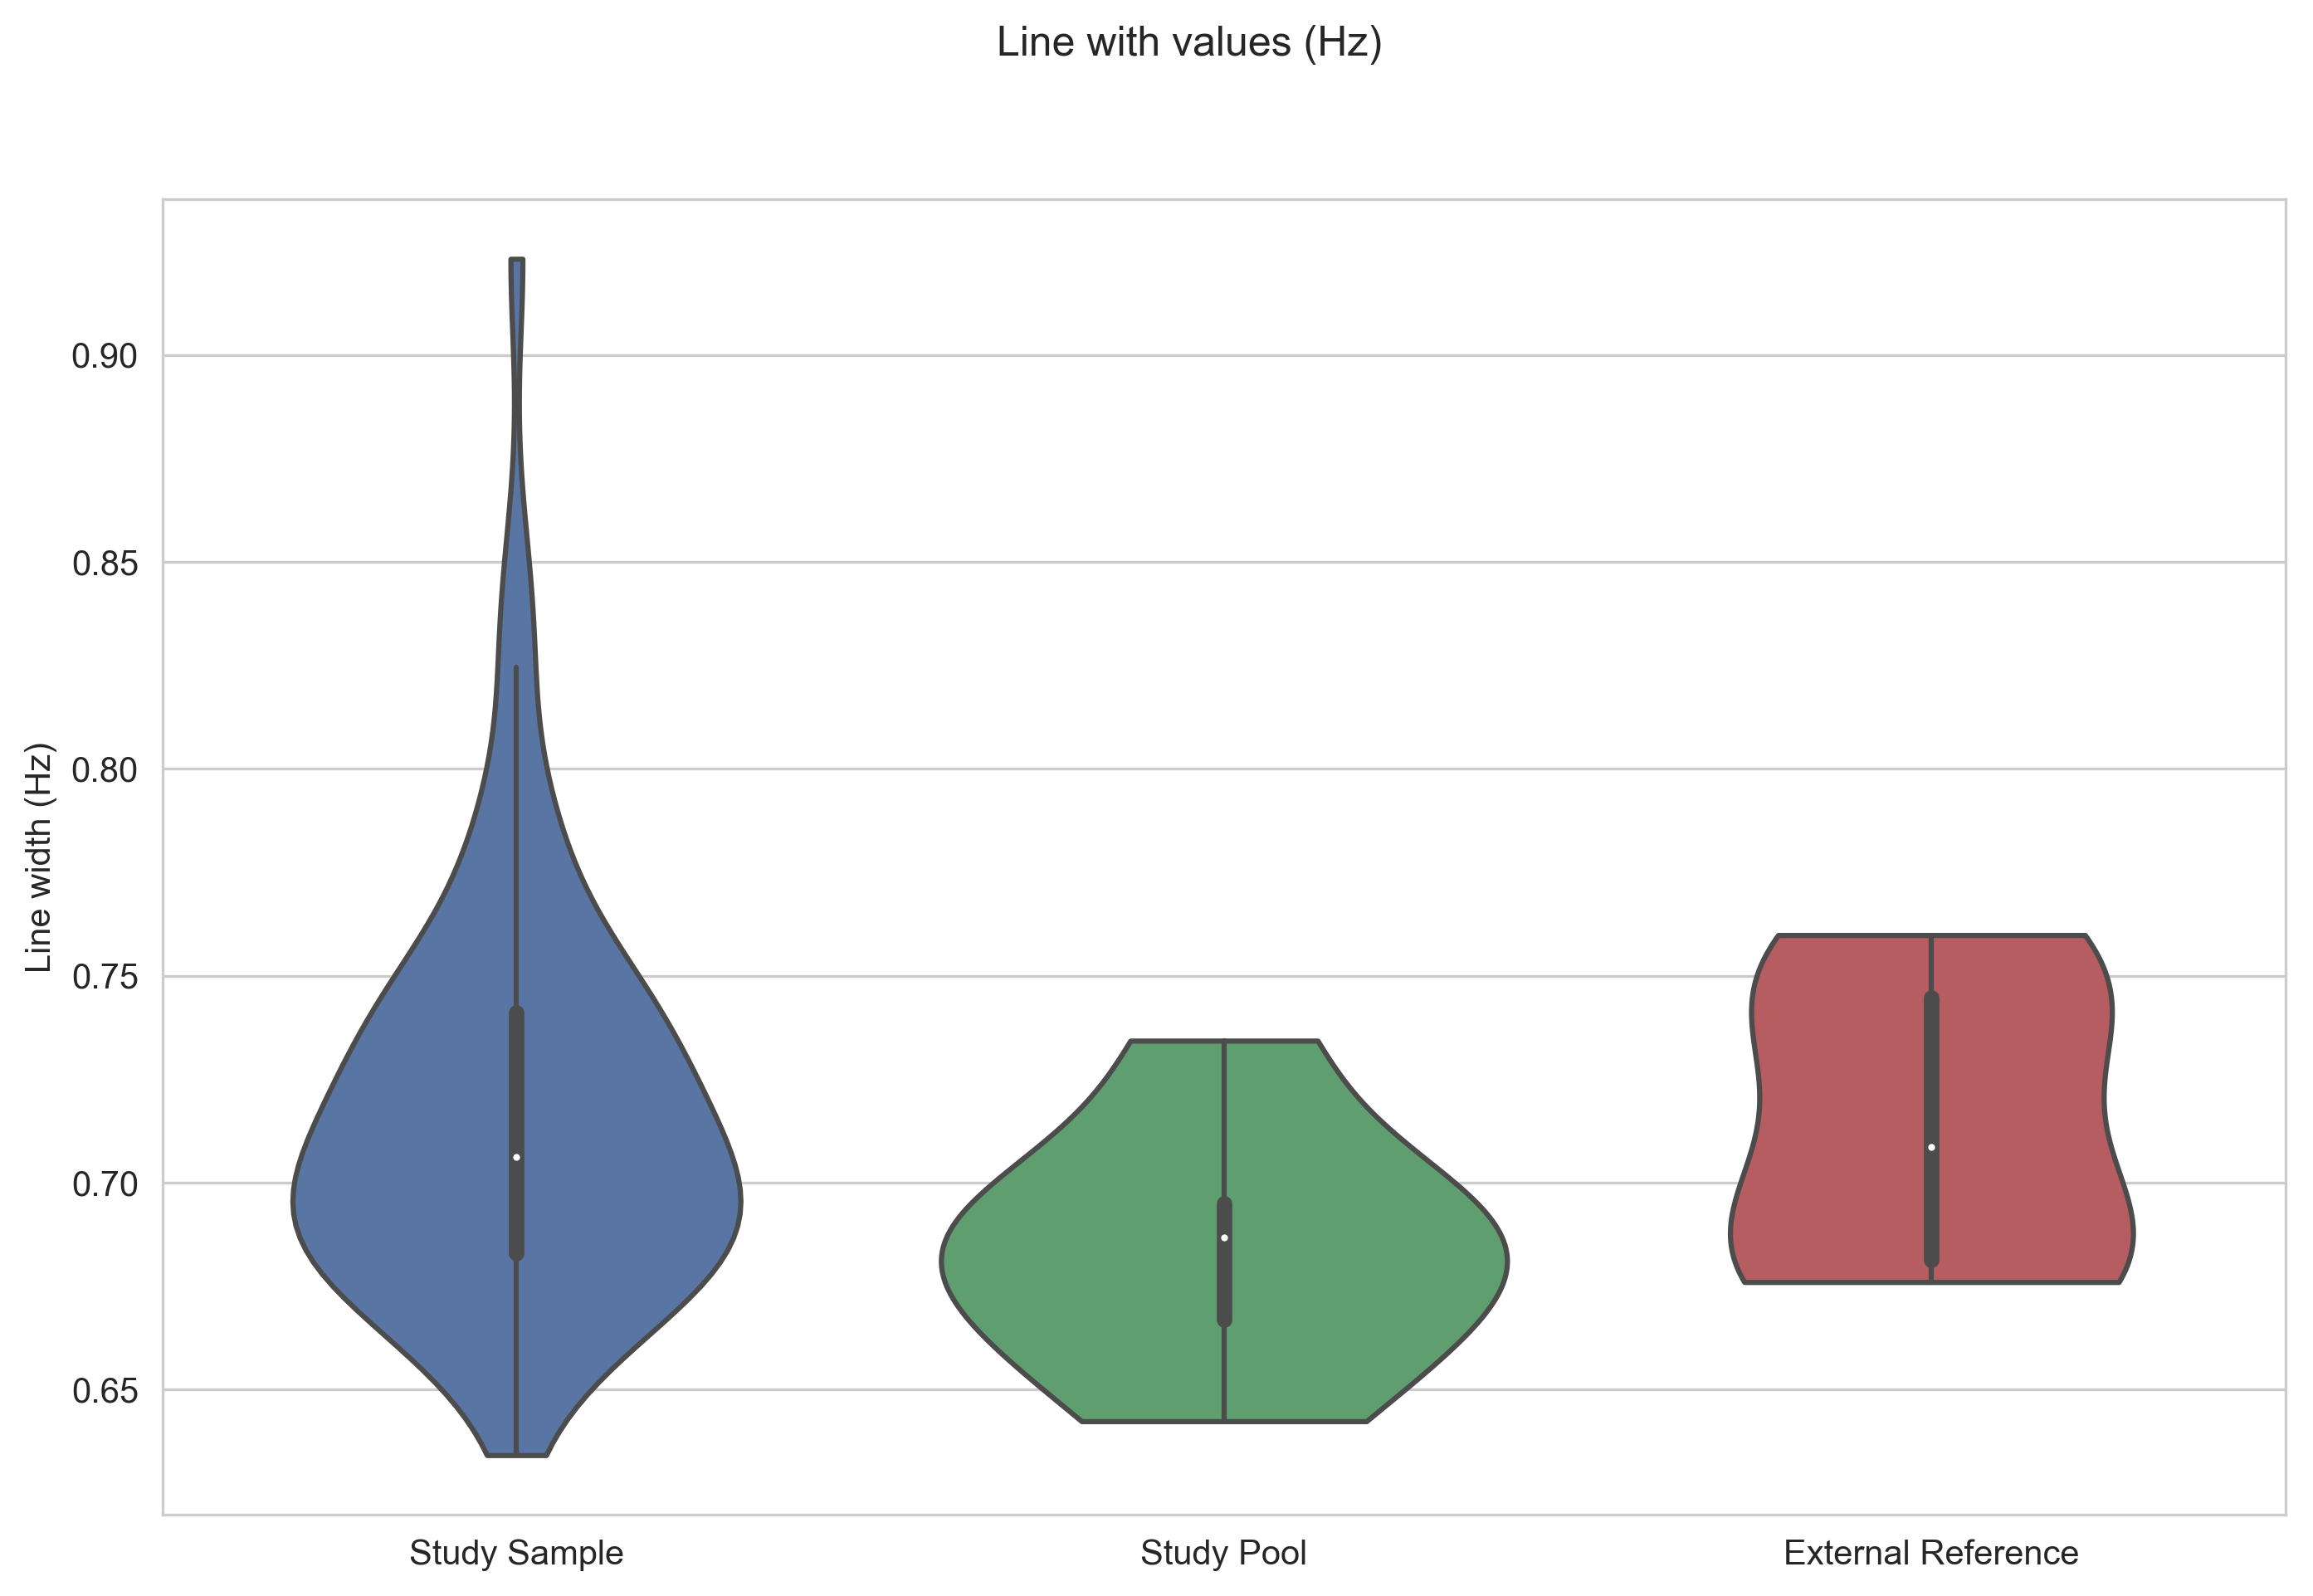

Figure 2a: Peak Width Modeling


Figure 3: Baseline Low and High


Figure 4: Waterpeak Low and High


Table 1: Summary of samples considered for exclusion


,Sample File Name,LineWidthFail,CalibrationFail,BaselineFail,WaterPeakFail
53,DEVSET U 1D NMR raw data files/580,False,False,False,True


In [13]:
nPYc.reports.generateReport(nmrData, 'feature summary')

# 3. Exclude samples/features if required

<div style='background-color:#EEFFEC'>
    <font color='#0B6D01'>
        Remove samples which fail based on any of the above analytical criteria by applying the sample masks.
        <br/><br/>
        At this point we can also exclude any other samples which are not required by setting preferences with the 'sampleTypes' argument. In this example, we limit our dataset to study samples and quality control samples only.
        <br/><br/>
        To keep all features, set the 'filterFeatures' argument to False.
    </font>
</div>

In [ ]:
nmrData.updateMasks(sampleTypes=[SampleType.StudySample, SampleType.StudyPool], filterFeatures=False)

### Filter features

<div style='background-color:#EEFFEC'>
    <font color='#0B6D01'>
        Remove unwanted/uninformative regions of the spectrum (the defaults here are the TSP peak region and the region contaning the water pre-saturation signal) by updating the masks with 'filterFeatures=True'. Here, we also demonstrate removing an additional region between 8.4 and 8.5.
        <br/><br/>
        To keep all samples (as specified at the previous step) set the 'filterSamples' argument to False.
        <br/><br/>
        To summarise features retained/marked for exclusion use the feature summary report.
    </font>
</div>

In [ ]:
nmrData.updateMasks(filterSamples=False, filterFeatures=True)

In [ ]:
nmrData.updateMasks(filterSamples=False, filterFeatures=True, exclusionRegions=[(8.4, 8.5)])

In [ ]:
nPYc.reports.generateReport(nmrData,'feature summary')

### Permanently exclude masked samples/features

<div style='background-color:#EEFFEC'>
    <font color='#0B6D01'>
If happy with the samples and features masked for exclusion, apply these exclusions (permanently remove samples/features from the dataset) using the 'applyMasks' function.
    </font>
</div>

In [ ]:
nmrData.applyMasks()

# 4. Analytical Multivariate Quality Control

<div style='background-color:#EEFFEC'>
    <font color='#0B6D01'>
        The analytical multivariate report provides visualisations summarising the largest sources of variance in the dataset (by PCA) with particular emphasis on any potential analytical sources. Plots include:
        <ul>
        <li>Model statistics.</li>
        <li>Scores plots. This provides insight into the relationship between sample, for example, consistency of the QC samples, sample outliers etc. </li>
        <li>Loadings plots. This provides insight into the features with the largest variance in the dataset.</li>
        <li>Potential associations with analytical parameters. Correlation (for continuous metadata) or Kruskal-Wallis test (for categorical metadata) between each metadata field and each set of PCA scores generated, any significant associations are flagged.</li>
        <li>The default scaling is unit variance ('scaling=1'), but other scaling options are available (0 for means centering; 0.5 for Pareto scaling)</li>
        </ul>
    </font>
</div>

In [ ]:
PCAmodelAnalytical = nPYc.multivariate.exploratoryAnalysisPCA(nmrData, scaling=1)

In [ ]:
nPYc.reports.multivariateQCreport(nmrData, PCAmodelAnalytical)

# 5. Finalise & Export Dataset

### Check final dataset output:

In [ ]:
nPYc.reports.generateReport(nmrData, 'final report', pcaModel=PCAmodelAnalytical)

### Export data:

<div style='background-color:#EEFFEC'>
    <font color='#0B6D01'>
    Export a unified csv file, which contains the intensity data (one row per sample, one column per variable), alongside all sample and feature metadata (left columns and top rows respectively).
    <br/><br/>
    Output the final report to provide a summary of the dataset.
    </font>
</div>

In [ ]:
if not os.path.exists(saveDir):
    os.makedirs(saveDir)

In [ ]:
nmrData.exportDataset(saveFormat='UnifiedCSV', destinationPath=saveDir)

In [ ]:
nPYc.reports.generateReport(nmrData, 'final report', pcaModel=PCAmodelAnalytical, destinationPath=saveDir)